In [442]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_fill_holes

%matplotlib inline

In [528]:
def pad_resize(img):
    top = int((224 - img.shape[0])/2)
    left = int((224 - img.shape[1])/2)
    bottom = 224 - img.shape[0] - top
    right = 224 - img.shape[1] - left
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
    img = img/255.
    img = cv2.resize(img, (50,50)) #KADD
    return img

def skeletonize(img):
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    img = cv2.bitwise_not(img)
#     element = cv2.getStructuringElement(cv2.MORPH_CROSS,(1,1))
#     done = 0
#     while( done < 1 ):
#         eroded = cv2.erode(img,element)
#         temp = cv2.dilate(eroded,element)
#         temp = cv2.subtract(img,temp)
#         skel = cv2.bitwise_or(skel,temp)
#         img = eroded.copy()

#         zeros = size - cv2.countNonZero(img)
#         if zeros==size:#cv2.countNonZero(img) * 1 >= 0:#
#             done += 1
#     img = skel
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 2)
    img = cv2.bitwise_not(erosion)
    return img

In [553]:
PATH = '../train_images_modified'
images = []
base_class = []
matra_class = []
total_class = []
for filename in os.listdir(PATH):
    if filename.endswith(".png"):
        img = cv2.imread(os.path.join(PATH,filename),0)
        blur = cv2.GaussianBlur(img,(9,9),0)# KADD
        a,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)#KEDIT
#         plt.imshow(img, cmap='gray')
#         plt.show()
# #         kernel = np.ones((5,5),np.uint8)
#         img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#         plt.imshow(img, cmap='gray')
#         plt.show()
        #img = skeletonize(img)
        img = pad_resize(img)
        blur = cv2.GaussianBlur(img,(9,9),0)# KADD
        char_arr = filename[:-4].split('_')[3:]
        if(len(char_arr)>0):
            images.append(img)
            char_arr = [int(i) for i in char_arr]
            total_class.append(char_arr)
            base = [i for i in char_arr if (i>=2308 and i<=2361) or (i==2384) or (i>=2392 and i<=2401) or (i>=2404 and i!=2416 and i!=2417)]  
            base_class.append(base[0])
#             if(len(char_arr)>1):          
#                 matra_class.append(char_arr[1:])
            if len(images)%100==0:
                print("{} Done".format(len(images)))
            
# print(len(images))
# print(len(char_class))
# print(images[0])
# print(char_class[0])

100 Done
200 Done
300 Done
400 Done
500 Done
600 Done
700 Done
800 Done
900 Done
1000 Done
1100 Done
1200 Done
1300 Done
1400 Done
1500 Done
1600 Done
1700 Done
1800 Done


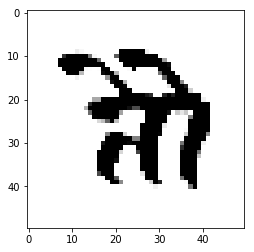

1895


In [554]:
plt.imshow(images[10],"gray")
plt.show()
print(len(images))

In [555]:
len(set(base_class))

53

In [576]:
images = np.array(images)
x_data = np.reshape(np.array(images), (-1, 50*50))
y_data = np.array(base_class)

df = pd.DataFrame(x_data, y_data)
df['LABEL'] = df.index

df_no_label = df.drop(columns='LABEL')

In [577]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import f1_score
# from sklearn.cross_validation import train_test_split

# #print(df.head())
# #print(df_no_label)
# #print(df['LABEL'])

# X_train,X_val,y_train,y_val = train_test_split(df_no_label, df['LABEL'])

# print(X_train.shape)
# print(X_val.shape)

# clf = RandomForestClassifier(max_features='auto', n_estimators=10, max_depth=20)
# clf.fit(X_train, y_train)

# scores = cross_val_score(clf, df_no_label, df['LABEL'], cv=3)
# print(scores)
# scores_f1 = f1_score(clf.predict(X_train),y_train,average='weighted')
# print(scores_f1)
# scores_f1 = f1_score(clf.predict(X_val),y_val,average='weighted')
# print(scores_f1)

In [578]:
import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
le.fit(base_class)
y_labeled = le.transform(base_class)
y_train = np_utils.to_categorical(y_labeled)

In [579]:
# model = Sequential()

# model.add(Dense(256,input_shape=(224*224,),activation = 'sigmoid'))
# model.add(Dense(128,activation = 'sigmoid'))
# model.add(Dense(128,activation = 'sigmoid'))
# model.add(Dense(len(total_char_set),activation = 'sigmoid'))

# print(model.summary())
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=[f1_score(theta=0.5),'accuracy'])
# X_train = X_train.reshape((-1,224*224))
# model.fit(X_train,y_train2,epochs=10,batch_size=32,validation_split=0.3)

In [589]:
print(y_train.shape)
x_train = np.reshape(images,(-1,50,50,1))
print(x_train.shape)

(1895, 53)
(1895, 50, 50, 1)


In [596]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten

model = Sequential()

model.add(Conv2D(16,(3,3),input_shape = (50,50,1),activation = 'relu'))
model.add(Conv2D(16,(3,3),activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPooling2D())
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256,activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(len(set(base_class)),activation = 'sigmoid'))

In [597]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 46, 46, 16)        2320      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 19, 19, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 32)          0         
__________

In [598]:
import keras.backend as K

def f1_score(theta):
    def score(y_true, y_pred):

        y_thresh = K.cast(K.greater(y_pred,theta),K.floatx())

        true_pos =  K.sum(y_true * y_thresh)
        false_pos = K.sum(y_true * (1. - y_thresh))
        false_neg = K.sum((1. - y_true) * y_thresh)

        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        f1_score_val = 2 * (precision * recall) / (precision + recall)
        return f1_score_val
    return score

def custom_metric(y_true, y_pred):
    return K.cast(K.equal(y_true,
                          K.round(y_pred)),
                  K.floatx())


In [599]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[f1_score(theta=0.5), 'categorical_accuracy'])

In [600]:
model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.3)

Train on 1326 samples, validate on 569 samples
Epoch 1/10
1326/1326 [==============================] - 11s 8ms/step - loss: 3.4834 - score: 0.0856 - categorical_accuracy: 0.0762 - val_loss: 3.5457 - val_score: 0.0837 - val_categorical_accuracy: 0.0879
Epoch 2/10
1326/1326 [==============================] - 9s 6ms/step - loss: 3.3213 - score: 0.1005 - categorical_accuracy: 0.0973 - val_loss: 3.5792 - val_score: 0.0881 - val_categorical_accuracy: 0.0879
Epoch 3/10
1326/1326 [==============================] - 9s 6ms/step - loss: 3.2958 - score: 0.1071 - categorical_accuracy: 0.0928 - val_loss: 3.5329 - val_score: 0.0960 - val_categorical_accuracy: 0.0879
Epoch 4/10
1326/1326 [==============================] - 11s 8ms/step - loss: 3.2870 - score: 0.1076 - categorical_accuracy: 0.1124 - val_loss: 3.4911 - val_score: 0.1082 - val_categorical_accuracy: 0.0879
Epoch 5/10
1326/1326 [==============================] - 9s 7ms/step - loss: 3.1114 - score: 0.1314 - categorical_accuracy: 0.1154 - val

KeyboardInterrupt: 

In [ ]:
preds = model.predict(X_train)

In [157]:
labels = np.zeros(preds[0].shape)
labels[preds[5]>0.5] = 1
labels[0]

0.0